In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define

In [3]:
# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6


# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', 't_dt']].values
X_scaled = custom_scaling(X)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

# Modular

## delta_current,delta_voltage

In [4]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_1 = df[["delta_current", "delta_voltage"]].values
# Define custom scaling ranges for each input feature

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_1, y_temp_1     = train_test_split(X_scaled, y_1, test_size=0.3, random_state=42)
X_val, X_test, y_val_1, y_test_1 = train_test_split(X_temp, y_temp_1, test_size=0.5, random_state=42)

histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1= {}
r2_scores_1 = {}
mapes_1 = {}




Epoch 1/100, Loss: 11.441192626953125, Val Loss: 9.536487579345703
Epoch 2/100, Loss: 7.700338840484619, Val Loss: 6.351037502288818
Epoch 3/100, Loss: 6.826179027557373, Val Loss: 5.331471920013428
Epoch 4/100, Loss: 5.982051372528076, Val Loss: 4.240758895874023
Epoch 5/100, Loss: 5.231260776519775, Val Loss: 3.4144997596740723
Epoch 6/100, Loss: 4.903305530548096, Val Loss: 3.1535634994506836
Epoch 7/100, Loss: 4.694540500640869, Val Loss: 2.9203004837036133
Epoch 8/100, Loss: 4.619746685028076, Val Loss: 2.862123727798462
Epoch 9/100, Loss: 4.546179294586182, Val Loss: 2.8422586917877197
Epoch 10/100, Loss: 4.523209095001221, Val Loss: 2.838167428970337
Epoch 11/100, Loss: 4.446353912353516, Val Loss: 2.7054505348205566
Epoch 12/100, Loss: 4.394576072692871, Val Loss: 2.646348476409912
Epoch 13/100, Loss: 4.270286560058594, Val Loss: 2.602583169937134
Epoch 14/100, Loss: 4.350148677825928, Val Loss: 2.508532762527466
Epoch 15/100, Loss: 4.250584602355957, Val Loss: 2.34909749031

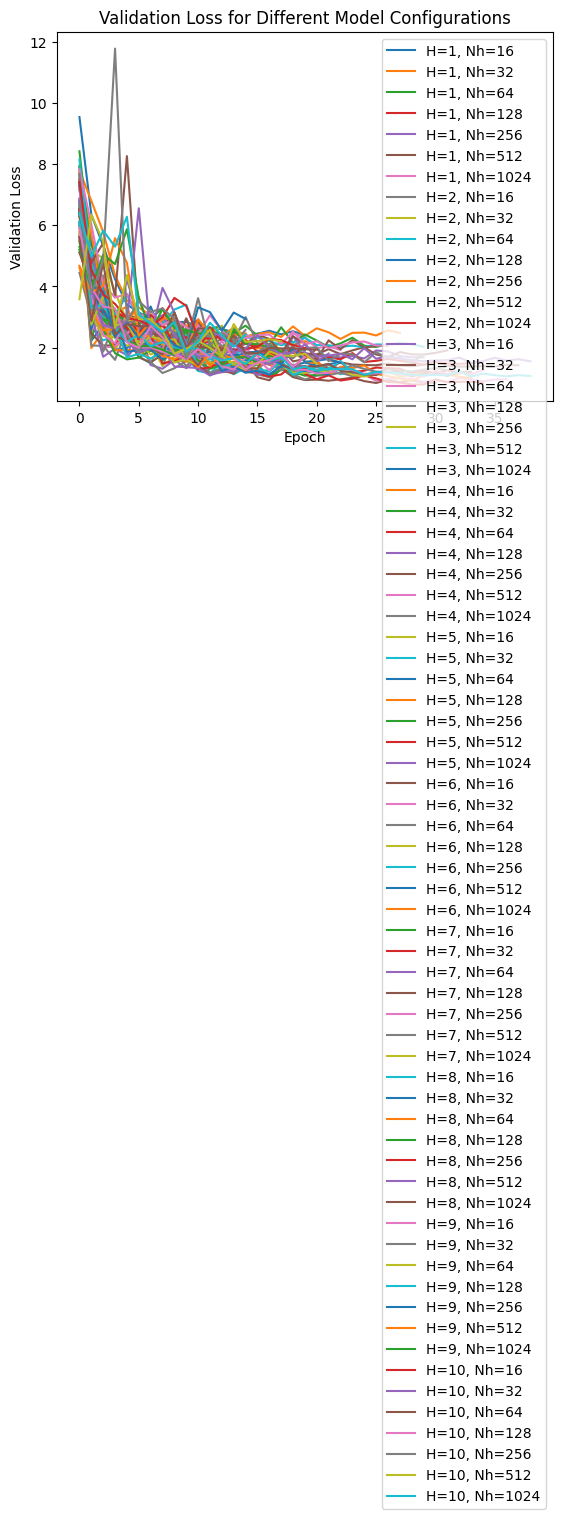

In [5]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(2, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train, y_train_1, epochs=100, batch_size=32, validation_data=(X_val, y_val_1), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test, y_test_1)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test_1, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test_1, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test_1, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test_1 - predictions_1) / y_test_1)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_1 in mses_1.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_1}')
#     print(f'MAE: {maes_1[(H, Nh)]}')
#     print(f'RMSE: {rmses_1[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_1[(H, Nh)]}')
#     print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [6]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
print('delta_current,delta_voltage')
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


delta_current,delta_voltage
Rank 1: Combination H=5, Nh=512 - MSE: 0.7539912462234497
Rank 2: Combination H=4, Nh=256 - MSE: 0.8369960784912109
Rank 3: Combination H=4, Nh=512 - MSE: 0.8462257385253906
Rank 4: Combination H=4, Nh=1024 - MSE: 0.937786877155304
Rank 5: Combination H=5, Nh=128 - MSE: 0.9427468180656433
Rank 6: Combination H=7, Nh=128 - MSE: 1.0094548463821411
Rank 7: Combination H=3, Nh=512 - MSE: 1.0149165391921997
Rank 8: Combination H=6, Nh=128 - MSE: 1.0429883003234863
Rank 9: Combination H=5, Nh=256 - MSE: 1.0432695150375366
Rank 10: Combination H=9, Nh=128 - MSE: 1.0664269924163818
Rank 11: Combination H=5, Nh=1024 - MSE: 1.0737133026123047
Rank 12: Combination H=6, Nh=256 - MSE: 1.0898531675338745
Rank 13: Combination H=7, Nh=256 - MSE: 1.0929003953933716
Rank 14: Combination H=4, Nh=128 - MSE: 1.1002824306488037
Rank 15: Combination H=6, Nh=512 - MSE: 1.128911018371582
Rank 16: Combination H=4, Nh=64 - MSE: 1.1587620973587036
Rank 17: Combination H=6, Nh=64 - MSE:

## Pl_s1,Pl_s2

In [7]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_2 = df[["Pl_s1"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_2, y_temp_2 = train_test_split(X_scaled, y_2, test_size=0.3, random_state=42)
X_val, X_test, y_val_2, y_test_2 = train_test_split(X_temp, y_temp_2, test_size=0.5, random_state=42)


histories_2 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_2 = {}
maes_2 = {}
rmses_2= {}
r2_scores_2 = {}
mapes_2 = {}

Epoch 1/100, Loss: 0.36169764399528503, Val Loss: 0.10649958997964859
Epoch 2/100, Loss: 0.11267636716365814, Val Loss: 0.08629423379898071
Epoch 3/100, Loss: 0.09893742948770523, Val Loss: 0.07887598127126694
Epoch 4/100, Loss: 0.0936465859413147, Val Loss: 0.06769540905952454
Epoch 5/100, Loss: 0.09316964447498322, Val Loss: 0.10084465146064758
Epoch 6/100, Loss: 0.09092607349157333, Val Loss: 0.05666244029998779
Epoch 7/100, Loss: 0.09064056724309921, Val Loss: 0.0598156712949276
Epoch 8/100, Loss: 0.08668828010559082, Val Loss: 0.056648265570402145
Epoch 9/100, Loss: 0.08652966469526291, Val Loss: 0.09032564610242844
Epoch 10/100, Loss: 0.08716516196727753, Val Loss: 0.05375618487596512
Epoch 11/100, Loss: 0.08377222716808319, Val Loss: 0.05473054572939873
Epoch 12/100, Loss: 0.08577558398246765, Val Loss: 0.08037082105875015
Epoch 13/100, Loss: 0.08527565747499466, Val Loss: 0.05647739768028259
Epoch 14/100, Loss: 0.08291440457105637, Val Loss: 0.051623713225126266
Epoch 15/100, L

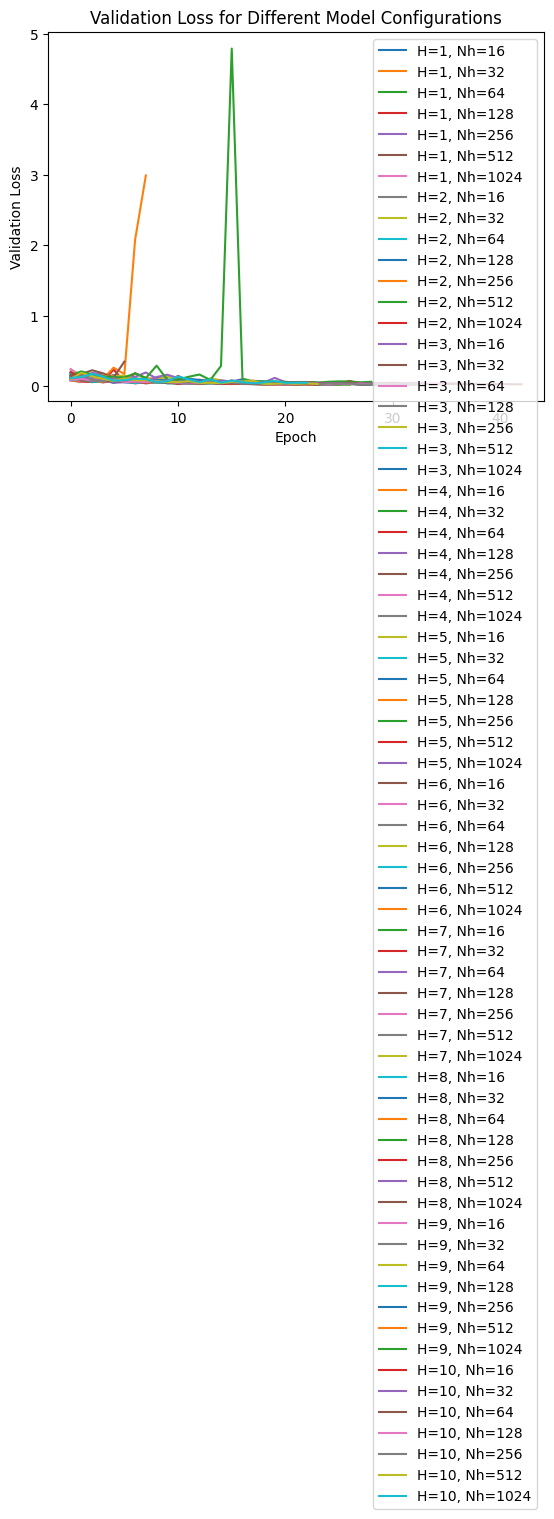

In [8]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_2 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_2.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_2.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_2.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_2.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_2.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_2.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_2 = model_2.fit(X_train, y_train_2, epochs=100, batch_size=32, validation_data=(X_val, y_val_2), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_2[(H, Nh)] = history_2

        # Evaluate the model on the testing set
        predictions_2 = model_2.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_2 = model_2.evaluate(X_test, y_test_2)
        mses_2[(H, Nh)] = mse_2

        # Calculate Mean Absolute Error (MAE)
        mae_2 = mean_absolute_error(y_test_2, predictions_2)
        maes_2[(H, Nh)] = mae_2

        # Calculate Root Mean Squared Error (RMSE)
        rmse_2 = np.sqrt(mean_squared_error(y_test_2, predictions_2))
        rmses_2[(H, Nh)] = rmse_2

        # Calculate R-squared (R2) Score
        r2_2 = r2_score(y_test_2, predictions_2)
        r2_scores_2[(H, Nh)] = r2_2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_2 = np.mean(np.abs((y_test_2 - predictions_2) / y_test_2)) * 100
        mapes_2[(H, Nh)] = mape_2

# Plot the validation loss for each configuration
for (H, Nh), history_2 in histories_2.items():
    plt.plot(history_2.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [9]:
# Rank combinations based on their MSE values
ranked_combinations_2 = sorted(mses_2.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_s1,Pl_s2')
for idx, ((H, Nh), mse_2) in enumerate(ranked_combinations_2, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_2}")


Pl_s1,Pl_s2
Rank 1: Combination H=7, Nh=128 - MSE: 0.021936260163784027
Rank 2: Combination H=5, Nh=256 - MSE: 0.022193951532244682
Rank 3: Combination H=10, Nh=128 - MSE: 0.023167066276073456
Rank 4: Combination H=8, Nh=256 - MSE: 0.023171447217464447
Rank 5: Combination H=9, Nh=256 - MSE: 0.023213153705000877
Rank 6: Combination H=10, Nh=256 - MSE: 0.023295365273952484
Rank 7: Combination H=4, Nh=256 - MSE: 0.02371286414563656
Rank 8: Combination H=1, Nh=1024 - MSE: 0.023732325062155724
Rank 9: Combination H=2, Nh=256 - MSE: 0.024003038182854652
Rank 10: Combination H=4, Nh=128 - MSE: 0.024955710396170616
Rank 11: Combination H=7, Nh=256 - MSE: 0.024969957768917084
Rank 12: Combination H=10, Nh=64 - MSE: 0.025236181914806366
Rank 13: Combination H=5, Nh=128 - MSE: 0.02532304637134075
Rank 14: Combination H=5, Nh=64 - MSE: 0.026072455570101738
Rank 15: Combination H=8, Nh=128 - MSE: 0.02619234472513199
Rank 16: Combination H=2, Nh=1024 - MSE: 0.026273168623447418
Rank 17: Combination 

## Pl_C

In [10]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_3 = df[["Pl_C"]].values
# Define custom scaling ranges for each input feature

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_3, y_temp_3     = train_test_split(X_scaled, y_3, test_size=0.3, random_state=42)
X_val, X_test, y_val_3, y_test_3 = train_test_split(X_temp, y_temp_3, test_size=0.5, random_state=42)

histories_3 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_3 = {}
maes_3 = {}
rmses_3= {}
r2_scores_3 = {}
mapes_3 = {}

Epoch 1/100, Loss: 0.1840830296278, Val Loss: 0.014229193329811096
Epoch 2/100, Loss: 0.011878672055900097, Val Loss: 0.007635300047695637
Epoch 3/100, Loss: 0.010251975618302822, Val Loss: 0.006860734894871712
Epoch 4/100, Loss: 0.00930753629654646, Val Loss: 0.006815792061388493
Epoch 5/100, Loss: 0.009093023836612701, Val Loss: 0.0061825779266655445
Epoch 6/100, Loss: 0.008877850137650967, Val Loss: 0.0060010976158082485
Epoch 7/100, Loss: 0.009231106378138065, Val Loss: 0.006698650773614645
Epoch 8/100, Loss: 0.00885458942502737, Val Loss: 0.005971595644950867
Epoch 9/100, Loss: 0.00913399551063776, Val Loss: 0.00706143444404006
Epoch 10/100, Loss: 0.008718300610780716, Val Loss: 0.005700298584997654
Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping
134/134 [==============================] - 0s 461us/step - loss: 0.0064
Epoch 1/100, Loss: 0.13461101055145264, Val Loss: 0.013049216940999031
Epoch 2/100, Loss: 0.010838114656507969, Val Loss: 0.007720

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


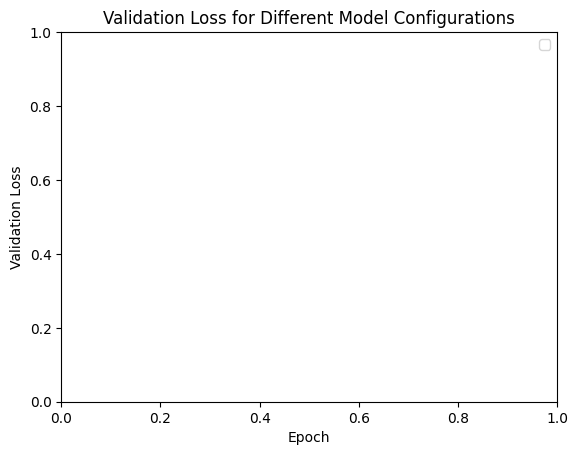

In [11]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_3 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_3.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_3.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_3.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_3.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_3.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_3.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_3 = model_3.fit(X_train, y_train_3, epochs=100, batch_size=32, validation_data=(X_val, y_val_3), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_3

        # Evaluate the model on the testing set
        predictions_3 = model_3.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_3 = model_3.evaluate(X_test, y_test_3)
        mses_3[(H, Nh)] = mse_3

        # Calculate Mean Absolute Error (MAE)
        mae_3 = mean_absolute_error(y_test_3, predictions_3)
        maes_3[(H, Nh)] = mae_3

        # Calculate Root Mean Squared Error (RMSE)
        rmse_3 = np.sqrt(mean_squared_error(y_test_3, predictions_3))
        rmses_3[(H, Nh)] = rmse_3

        # Calculate R-squared (R2) Score
        r2_3 = r2_score(y_test_3, predictions_3)
        r2_scores_3[(H, Nh)] = r2_3

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_3 = np.mean(np.abs((y_test_3 - predictions_3) / y_test_3)) * 100
        mapes_3[(H, Nh)] = mape_3

# Plot the validation loss for each configuration
for (H, Nh), history_3 in histories_3.items():
    plt.plot(history_3.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_1 in mses_1.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_1}')
#     print(f'MAE: {maes_1[(H, Nh)]}')
#     print(f'RMSE: {rmses_1[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_1[(H, Nh)]}')
#     print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [12]:
# Rank combinations based on their MSE values
ranked_combinations_3 = sorted(mses_3.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_C')
for idx, ((H, Nh), mse_3) in enumerate(ranked_combinations_3, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_3}")


Pl_C
Rank 1: Combination H=3, Nh=128 - MSE: 0.0019117664778605103
Rank 2: Combination H=9, Nh=256 - MSE: 0.0019326865440234542
Rank 3: Combination H=3, Nh=512 - MSE: 0.002151770982891321
Rank 4: Combination H=2, Nh=256 - MSE: 0.0023038561921566725
Rank 5: Combination H=8, Nh=512 - MSE: 0.0025124987587332726
Rank 6: Combination H=3, Nh=64 - MSE: 0.002562544774264097
Rank 7: Combination H=4, Nh=512 - MSE: 0.002694597002118826
Rank 8: Combination H=7, Nh=128 - MSE: 0.0027339018415659666
Rank 9: Combination H=6, Nh=512 - MSE: 0.002763432916253805
Rank 10: Combination H=4, Nh=256 - MSE: 0.002867778530344367
Rank 11: Combination H=9, Nh=32 - MSE: 0.0028913028072565794
Rank 12: Combination H=3, Nh=256 - MSE: 0.002897226484492421
Rank 13: Combination H=9, Nh=1024 - MSE: 0.0030025711748749018
Rank 14: Combination H=7, Nh=256 - MSE: 0.00306823686696589
Rank 15: Combination H=10, Nh=256 - MSE: 0.003102055052295327
Rank 16: Combination H=4, Nh=64 - MSE: 0.0031214242335408926
Rank 17: Combination H

## Pl_L_Cu

In [13]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_4 = df[["Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_4, y_temp_4 = train_test_split(X_scaled, y_4, test_size=0.3, random_state=42)
X_val, X_test, y_val_4, y_test_4 = train_test_split(X_temp, y_temp_4, test_size=0.5, random_state=42)


histories_4 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_4 = {}
maes_4 = {}
rmses_4= {}
r2_scores_4 = {}
mapes_4 = {}

Epoch 1/100, Loss: 0.2218448668718338, Val Loss: 0.15776027739048004
Epoch 2/100, Loss: 0.15447020530700684, Val Loss: 0.11374121904373169
Epoch 3/100, Loss: 0.13981777429580688, Val Loss: 0.10009211301803589
Epoch 4/100, Loss: 0.1318608671426773, Val Loss: 0.09184557944536209
Epoch 5/100, Loss: 0.12660400569438934, Val Loss: 0.09078364819288254
Epoch 6/100, Loss: 0.12565484642982483, Val Loss: 0.08583839982748032
Epoch 7/100, Loss: 0.12115789949893951, Val Loss: 0.08563971519470215
Epoch 8/100, Loss: 0.12078087031841278, Val Loss: 0.07772292196750641
Epoch 9/100, Loss: 0.1197323277592659, Val Loss: 0.08533717691898346
Epoch 10/100, Loss: 0.11703839153051376, Val Loss: 0.07827842235565186
Epoch 11/100, Loss: 0.11222860962152481, Val Loss: 0.07158005237579346
Epoch 12/100, Loss: 0.11818582564592361, Val Loss: 0.07146362215280533
Epoch 13/100, Loss: 0.11298346519470215, Val Loss: 0.0769987627863884
Epoch 14/100, Loss: 0.11052077263593674, Val Loss: 0.08060415834188461
Epoch 15/100, Loss:

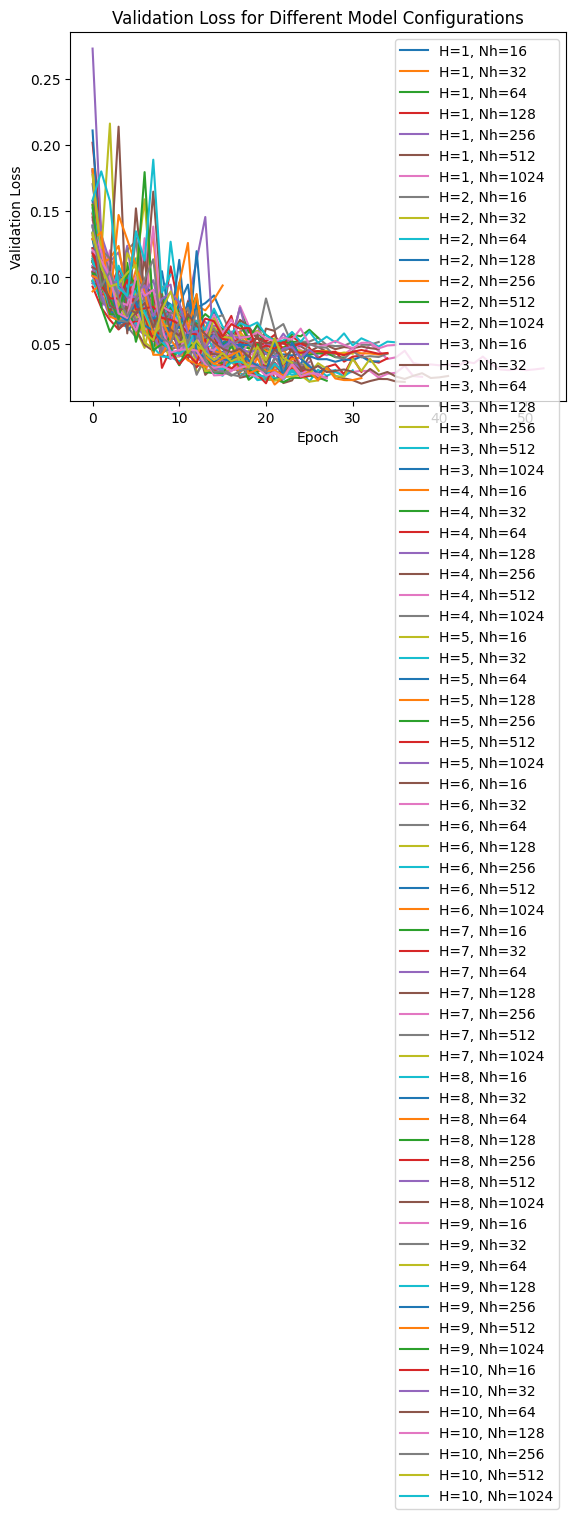

In [14]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_4 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_4.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_4.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_4.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_4.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_4.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_4.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_4 = model_4.fit(X_train, y_train_4, epochs=100, batch_size=32, validation_data=(X_val, y_val_4), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_4[(H, Nh)] = history_4

        # Evaluate the model on the testing set
        predictions_4 = model_4.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_4 = model_4.evaluate(X_test, y_test_4)
        mses_4[(H, Nh)] = mse_4

        # Calculate Mean Absolute Error (MAE)
        mae_4 = mean_absolute_error(y_test_4, predictions_4)
        maes_4[(H, Nh)] = mae_4

        # Calculate Root Mean Squared Error (RMSE)
        rmse_4 = np.sqrt(mean_squared_error(y_test_4, predictions_4))
        rmses_4[(H, Nh)] = rmse_4

        # Calculate R-squared (R2) Score
        r2_4 = r2_score(y_test_4, predictions_4)
        r2_scores_4[(H, Nh)] = r2_4

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_4 = np.mean(np.abs((y_test_4 - predictions_4) / y_test_4)) * 100
        mapes_4[(H, Nh)] = mape_4

# Plot the validation loss for each configuration
for (H, Nh), history_4 in histories_4.items():
    plt.plot(history_4.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [15]:
# Rank combinations based on their MSE values
ranked_combinations_4 = sorted(mses_4.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_L_Cu')
for idx, ((H, Nh), mse_4) in enumerate(ranked_combinations_4, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_4}")


Pl_L_Cu
Rank 1: Combination H=6, Nh=1024 - MSE: 0.0193583145737648
Rank 2: Combination H=7, Nh=128 - MSE: 0.019479352980852127
Rank 3: Combination H=8, Nh=256 - MSE: 0.019885439425706863
Rank 4: Combination H=5, Nh=256 - MSE: 0.02079247683286667
Rank 5: Combination H=4, Nh=256 - MSE: 0.020918546244502068
Rank 6: Combination H=3, Nh=512 - MSE: 0.021774817258119583
Rank 7: Combination H=9, Nh=512 - MSE: 0.02215067856013775
Rank 8: Combination H=6, Nh=128 - MSE: 0.022678233683109283
Rank 9: Combination H=6, Nh=256 - MSE: 0.022828483954072
Rank 10: Combination H=7, Nh=512 - MSE: 0.023088708519935608
Rank 11: Combination H=10, Nh=64 - MSE: 0.023131566122174263
Rank 12: Combination H=7, Nh=256 - MSE: 0.02352426014840603
Rank 13: Combination H=10, Nh=128 - MSE: 0.02371552214026451
Rank 14: Combination H=2, Nh=1024 - MSE: 0.02405187487602234
Rank 15: Combination H=9, Nh=128 - MSE: 0.024536265060305595
Rank 16: Combination H=3, Nh=64 - MSE: 0.02470472827553749
Rank 17: Combination H=9, Nh=256 -

## P_D

In [16]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_5 = df[["P_D"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_5, y_temp_5 = train_test_split(X_scaled, y_5, test_size=0.3, random_state=42)
X_val, X_test, y_val_5, y_test_5 = train_test_split(X_temp, y_temp_5, test_size=0.5, random_state=42)


histories_5 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_5 = {}
maes_5 = {}
rmses_5= {}
r2_scores_5 = {}
mapes_5 = {}

Epoch 1/100, Loss: 0.1310209333896637, Val Loss: 0.01876121759414673
Epoch 2/100, Loss: 0.015392406843602657, Val Loss: 0.024271737784147263
Epoch 3/100, Loss: 0.013415777124464512, Val Loss: 0.010941589251160622
Epoch 4/100, Loss: 0.011420262977480888, Val Loss: 0.008653484284877777
Epoch 5/100, Loss: 0.010204019956290722, Val Loss: 0.012416602112352848
Epoch 6/100, Loss: 0.009508811868727207, Val Loss: 0.008625871501863003
Epoch 7/100, Loss: 0.009223762899637222, Val Loss: 0.005442867986857891
Epoch 8/100, Loss: 0.00897409487515688, Val Loss: 0.00542024290189147
Epoch 9/100, Loss: 0.008914139121770859, Val Loss: 0.006075469311326742
Epoch 10/100, Loss: 0.00875282846391201, Val Loss: 0.00876651331782341
Epoch 11/100, Loss: 0.008361860178411007, Val Loss: 0.005498850718140602
Epoch 12/100, Loss: 0.008747059851884842, Val Loss: 0.004994118586182594
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
134/134 [==============================] - 0s 461us/step

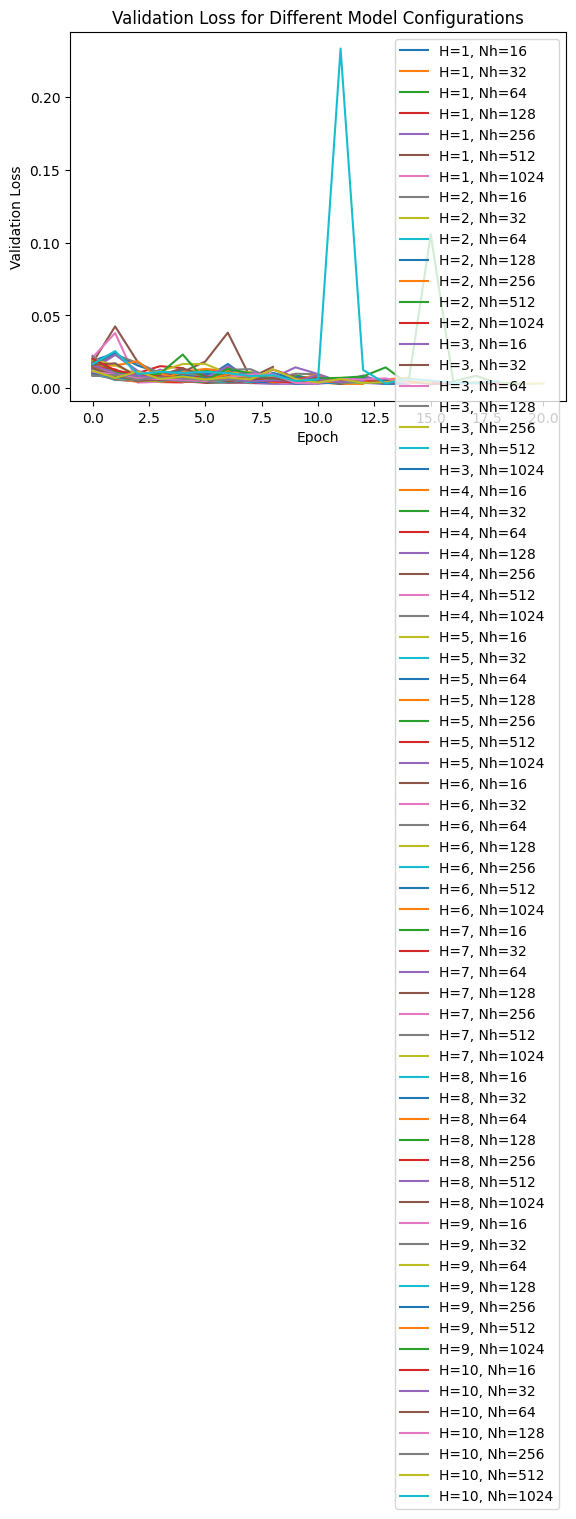

In [17]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_5 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_5.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_5.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_5.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_5.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_5.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_5.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_5 = model_5.fit(X_train, y_train_5, epochs=100, batch_size=32, validation_data=(X_val, y_val_5), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_5[(H, Nh)] = history_5

        # Evaluate the model on the testing set
        predictions_5 = model_5.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_5 = model_5.evaluate(X_test, y_test_5)
        mses_5[(H, Nh)] = mse_5

        # Calculate Mean Absolute Error (MAE)
        mae_5 = mean_absolute_error(y_test_5, predictions_5)
        maes_5[(H, Nh)] = mae_5

        # Calculate Root Mean Squared Error (RMSE)
        rmse_5 = np.sqrt(mean_squared_error(y_test_5, predictions_5))
        rmses_5[(H, Nh)] = rmse_5

        # Calculate R-squared (R2) Score
        r2_5 = r2_score(y_test_5, predictions_5)
        r2_scores_5[(H, Nh)] = r2_5

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_5 = np.mean(np.abs((y_test_5 - predictions_5) / y_test_5)) * 100
        mapes_5[(H, Nh)] = mape_5

# Plot the validation loss for each configuration
for (H, Nh), history_5 in histories_5.items():
    plt.plot(history_5.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [18]:
# Rank combinations based on their MSE values
ranked_combinations_5 = sorted(mses_5.items(), key=lambda x: x[1])

# Print ranked combinations
print('P_D')
for idx, ((H, Nh), mse_5) in enumerate(ranked_combinations_5, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_5}")


P_D
Rank 1: Combination H=9, Nh=1024 - MSE: 0.002929265145212412
Rank 2: Combination H=8, Nh=32 - MSE: 0.003090755082666874
Rank 3: Combination H=6, Nh=512 - MSE: 0.0031699538230895996
Rank 4: Combination H=2, Nh=32 - MSE: 0.003225957276299596
Rank 5: Combination H=10, Nh=1024 - MSE: 0.0032516636420041323
Rank 6: Combination H=6, Nh=128 - MSE: 0.003299914300441742
Rank 7: Combination H=8, Nh=1024 - MSE: 0.0033082824666053057
Rank 8: Combination H=1, Nh=256 - MSE: 0.0033223056234419346
Rank 9: Combination H=6, Nh=1024 - MSE: 0.003436950733885169
Rank 10: Combination H=3, Nh=1024 - MSE: 0.0034551259595900774
Rank 11: Combination H=2, Nh=256 - MSE: 0.003503579180687666
Rank 12: Combination H=4, Nh=512 - MSE: 0.0036120598670095205
Rank 13: Combination H=7, Nh=64 - MSE: 0.0036174554843455553
Rank 14: Combination H=5, Nh=128 - MSE: 0.0036211630795150995
Rank 15: Combination H=10, Nh=16 - MSE: 0.0036252818536013365
Rank 16: Combination H=10, Nh=128 - MSE: 0.003681809874251485
Rank 17: Combina

# All

In [23]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling_1(X)


# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

Epoch 1/100, Loss: 554.0697021484375, Val Loss: 377.0353698730469
Epoch 2/100, Loss: 361.8121643066406, Val Loss: 225.14125061035156
Epoch 3/100, Loss: 261.9071960449219, Val Loss: 155.34043884277344
Epoch 4/100, Loss: 197.71446228027344, Val Loss: 104.53741455078125
Epoch 5/100, Loss: 152.94808959960938, Val Loss: 67.61432647705078
Epoch 6/100, Loss: 118.61122131347656, Val Loss: 43.63121032714844
Epoch 7/100, Loss: 98.19184875488281, Val Loss: 31.27219009399414
Epoch 8/100, Loss: 81.76326751708984, Val Loss: 21.52593421936035
Epoch 9/100, Loss: 68.30577087402344, Val Loss: 18.812267303466797
Epoch 10/100, Loss: 60.238006591796875, Val Loss: 16.89008903503418
Epoch 11/100, Loss: 56.168174743652344, Val Loss: 18.007282257080078
Epoch 12/100, Loss: 50.1596794128418, Val Loss: 19.60795783996582
Epoch 13/100, Loss: 45.027305603027344, Val Loss: 17.871627807617188
Epoch 14/100, Loss: 47.69794845581055, Val Loss: 19.550479888916016
Epoch 15/100, Loss: 42.378231048583984, Val Loss: 22.634454

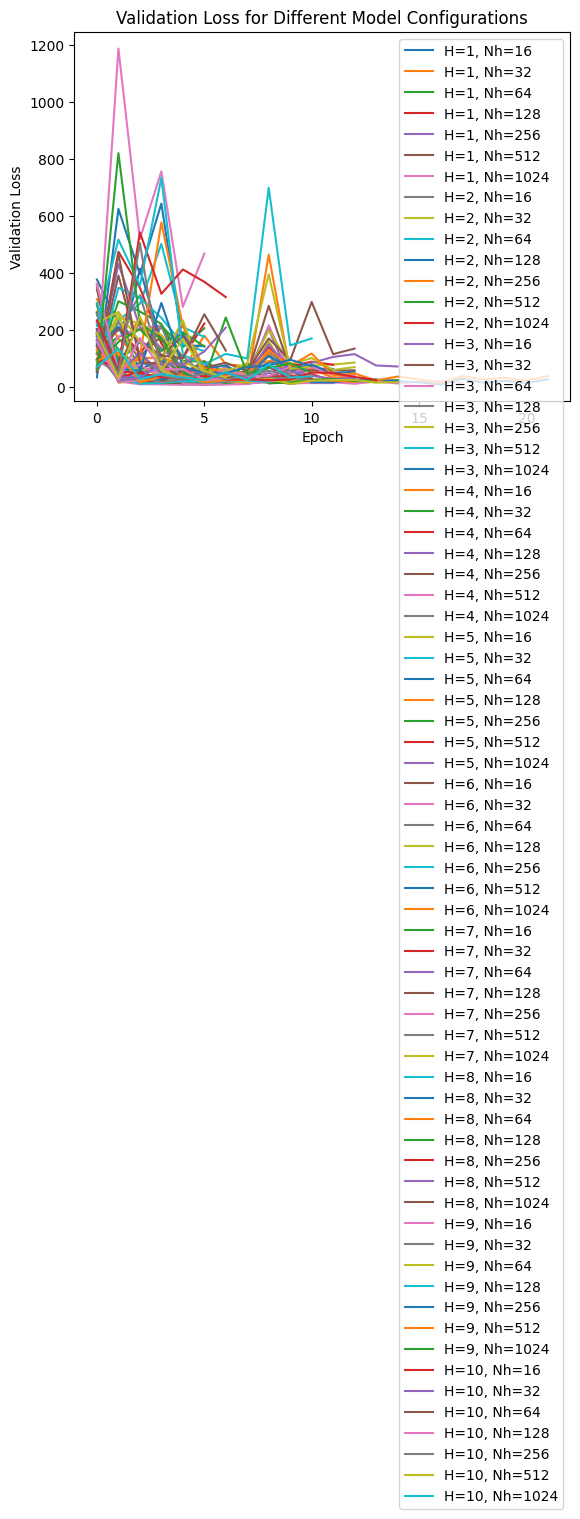

Model with H=1 and Nh=16:
MSE: 21.522748947143555
MAE: 1.421224059761084
RMSE: 4.639261802519753
R-squared: 0.40169949292383916
MAPE: 82.90404456117147%
Model with H=1 and Nh=32:
MSE: 19.896114349365234
MAE: 1.3706546345386308
RMSE: 4.460506392254801
R-squared: 0.18051774568255477
MAPE: 74.59606847037473%
Model with H=1 and Nh=64:
MSE: 13.621976852416992
MAE: 1.065860207307386
RMSE: 3.690796323801405
R-squared: 0.5073690089504838
MAPE: 41.74607059251466%
Model with H=1 and Nh=128:
MSE: 16.37964630126953
MAE: 1.1962126024477966
RMSE: 4.047177777082089
R-squared: 0.49497713641890834
MAPE: 45.36646187665527%
Model with H=1 and Nh=256:
MSE: 11.52580451965332
MAE: 0.9164689456483123
RMSE: 3.394967789207549
R-squared: 0.5054952504278679
MAPE: 34.06543129154509%
Model with H=1 and Nh=512:
MSE: 10.19467830657959
MAE: 0.8818764361504026
RMSE: 3.192910157228308
R-squared: 0.5036587595281389
MAPE: 32.677656234897306%
Model with H=1 and Nh=1024:
MSE: 10.088295936584473
MAE: 0.8809016229429427
RMSE

In [24]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


In [21]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=3, Nh=64 - MSE: 12.961284637451172
Rank 2: Combination H=3, Nh=128 - MSE: 13.115339279174805
Rank 3: Combination H=5, Nh=32 - MSE: 13.944125175476074
Rank 4: Combination H=1, Nh=128 - MSE: 15.415477752685547
Rank 5: Combination H=1, Nh=64 - MSE: 16.113615036010742
Rank 6: Combination H=3, Nh=16 - MSE: 16.397350311279297
Rank 7: Combination H=2, Nh=32 - MSE: 17.300172805786133
Rank 8: Combination H=4, Nh=32 - MSE: 17.322221755981445
Rank 9: Combination H=4, Nh=64 - MSE: 18.558258056640625
Rank 10: Combination H=4, Nh=16 - MSE: 18.917428970336914
Rank 11: Combination H=2, Nh=16 - MSE: 18.98853302001953
Rank 12: Combination H=2, Nh=128 - MSE: 22.346418380737305
Rank 13: Combination H=1, Nh=32 - MSE: 22.616371154785156
Rank 14: Combination H=3, Nh=32 - MSE: 22.952621459960938
Rank 15: Combination H=2, Nh=64 - MSE: 23.042673110961914
Rank 16: Combination H=5, Nh=64 - MSE: 24.71121597290039
Rank 17: Combination H=1, Nh=16 - MSE: 27.049293518066406
Rank 18: Combination H

# Try spesific N and H

In [22]:
# # Specify the combination you want to call
# H = 7
# Nh = 512

# # Retrieve the model for the specified combination
# selected_model_1 = histories_1[(H, Nh)].model
# selected_model_1.save("model_7_512_13_13.h5")
# # Use the trained model to make predictions on the testing set
# predictions_1 = selected_model_1.predict(X_test)

# # Evaluate the model on the testing set
# mse_1 = selected_model_1.evaluate(X_test, y_test)
# print("Mean Squared Error on Testing Set:", mse_1)

# # Print the first few predictions
# print("Predictions:")
# print(predictions_1[:5])

# # Print the corresponding true values
# print("True Values:")
# print(y_test[:5])